In [36]:
## Standard libraries
import os
import json
import math
import numpy as np

## Imports for plotting
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
import seaborn as sns
sns.set()

## Progress bar
from tqdm.notebook import tqdm

## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim

#https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/tutorial3/Activation_Functions.html

In this tutorial, we will take a closer look at (popular) activation functions and investigate their effect on optimization properties in neural networks. 
Activation functions are a crucial part of deep learning models as they add the non-linearity to neural networks.
There is a great variety of activation functions in the literature, and some are more beneficial than others.
The goal of this tutorial is to show the importance of choosing a good activation function (and how to do so), and what problems might occur if we don't.

Before we start, we import our standard libraries and set up basic functions.

We will define a function to set a seed on all libraries we might interact with in this tutorial (here numpy and torch). This allows us to make our training reproducible. However, note that in contrast to the CPU, the same seed on different GPU architectures can give different results. All models here have been trained on an NVIDIA GTX1080Ti, which is also the GPU type provided by the Lisa gpu_shared_course partition.

Additionally, the following cell defines two paths: `DATASET_PATH` and `CHECKPOINT_PATH`. The dataset path is the directory where we will download datasets used in the notebooks. It is recommended to store all datasets from PyTorch in one joined directory to prevent duplicate downloads. The checkpoint path is the directory where we will store trained model weights and additional files. The needed files will be automatically downloaded. In case you are on Google Colab, it is recommended to change the directories to start from the current directory (i.e. remove `../` for both dataset and checkpoint path).

In [2]:
DATASET_PATH = "/home/artur/Documents/TasksDeepNeuralNets/AmsterdamKourse/tutorial3_ActivationFunction/data/"
CHECKPOINT_PATH = "/home/artur/Documents/TasksDeepNeuralNets/AmsterdamKourse/tutorial3_ActivationFunction/saved_model/"

def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available(): # GPU operation have separate seed
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
set_seed(42)

# Additionally, some operations on a GPU are implemented stochastic for efficiency
# We want to ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cpu") if not torch.cuda.is_available else torch.device("cuda:0")
print(f"using devise {device}")


using devise cuda:0


In [3]:
import urllib.request
from urllib.error import HTTPError
# Github URL where saved models are stored for this tutorial

base_url = "https://github.com/phlippe/saved_models/tree/main/tutorial3/"

pretrained_files = ["FashionMNIST_elu.config", "FashionMNIST_elu.tar",
                    "FashionMNIST_leakyrelu.config", "FashionMNIST_leakyrelu.tar",
                    "FashionMNIST_relu.config", "FashionMNIST_relu.tar",
                    "FashionMNIST_sigmoid.config", "FashionMNIST_sigmoid.tar",
                    "FashionMNIST_swish.config", "FashionMNIST_swish.tar",
                    "FashionMNIST_tanh.config", "FashionMNIST_tanh.tar"]

# Create the checkpoint directory if it does not exist
os.makedirs(CHECKPOINT_PATH, exist_ok = True)

# For each file, check whether it already exist or not, if not try to download it
for file_name in pretrained_files:
    file_path = os.path.join(CHECKPOINT_PATH, file_name)
    if not os.path.isfile(file_path):
        file_url = base_url + file_name
        print(f"Downloading {file_url} ...")
        try:
            urlib.request.urlretrieve(file_url, file_path)
        except:
            print("Something went wrong")

## Common activation functions

As a first step, we will implement some common activation functions by ourselves. Of course, most of them can also be found in the `torch.nn` package (see the [documentation](https://pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity) for an overview).
However, we'll write our own functions here for a better understanding and insights.

For an easier time of comparing various activation functions, we start with defining a base class from which all our future modules will inherit

Every activation function will be an `nn.Module` so that we can integrate them nicely in a network. We will use the `config` dictionary to store adjustable parameters for some activation functions.

Next, we implement two of the "oldest" activation functions that are still commonly used for various tasks: sigmoid and tanh. 
Both the sigmoid and tanh activation can be also found as PyTorch functions (`torch.sigmoid`, `torch.tanh`) or as modules (`nn.Sigmoid`, `nn.Tanh`). 
Here, we implement them by hand:

In [4]:
class ActivationFunction(nn.Module):
    def __init__(self):
        super().__init__()
        self.name = self.__class__.__name__
        self.config = {"name": self.name}


# SIGMOID  SIGMOID  SIGMOID  SIGMOID  SIGMOID  
# SIGMOID  SIGMOID  SIGMOID  SIGMOID  SIGMOID  
class Sigmoid(ActivationFunction):
    def forward(self, x):
        return 1 / (1 + torch.exp(-x))


# TANH  TANH  TANH  TANH  TANH  TANH  TANH  
# TANH  TANH  TANH  TANH  TANH  TANH  TANH  
class Tanh(ActivationFunction):
    def forward(self, x):
        x_exp, neg_x_exp = torch.exp(x), torch.exp(-x)
        return (x_exp - neg_x_exp) / (x_exp + neg_x_exp)
    

Another popular activation function that has allowed the training of deeper networks, is the Rectified Linear Unit (ReLU). 
Despite its simplicity of being a piecewise linear function, ReLU has one major benefit compared to sigmoid and tanh: a strong, stable gradient for a large range of values.
Based on this idea, a lot of variations of ReLU have been proposed, of which we will implement the following three: LeakyReLU, ELU, and Swish. 
LeakyReLU replaces the zero settings in the negative part with a smaller slope to allow gradients to flow also in this part of the input.
Similarly, ELU replaces the negative part with an exponential decay.
The third, most recently proposed activation function is Swish, which is actually the result of a large experiment with the purpose of finding the "optimal" activation function. 
Compared to the other activation functions, Swish is both smooth and non-monotonic (i.e. contains a change of sign in the gradient).
This has been shown to prevent dead neurons as in standard ReLU activation, especially for deep networks. 
If interested, a more detailed discussion of the benefits of Swish can be found in [this paper](https://arxiv.org/abs/1710.05941) [1].

Let's implement the four activation functions below:

In [5]:
class ReLU(ActivationFunction):
    def forward(self, x):
        return x * (x > 0).float()

###################################################

class LeakyReLU(ActivationFunction):

    def __init__(self, alpha = 0.1):
        super().__init__()
        self.config["alpha"] = alpha #please see func ActivationFunction

    def forward(self, x):
        return torch.where(x>0, x, self.config["alpha"] * x)

################################################

class ELU(ActivationFunction):
    def forward(self, x):
        return torch.where(x>0, x, torch.exp(x) - 1)

################################################

class Swich(ActivationFunction):
    def forward(self, x):
        return x * torch.sigmoid(x)

In [6]:
act_fn_names = {
    "sigmoid": Sigmoid,
    "tanh": Tanh,
    "relu": ReLU,
    "leakyrelu":LeakyReLU,
    "elu":ELU,
    "swich":Swich    
}

### Visualizing the gradient flow after initialization

As mentioned previously, one important aspect of activation functions is how they propagate gradients through the network. Imagine we have a very deep neural network with more than 50 layers. The gradients for the input layer, i.e. the very first layer, have passed >50 times the activation function, but we still want them to be of a reasonable size. If the gradient through the activation function is (in expectation) considerably smaller than 1, our gradients will vanish until they reach the input layer. If the gradient through the activation function is larger than 1, the gradients exponentially increase and might explode. 

To get a feeling of how every activation function influences the gradients, we can look at a freshly initialized network and measure the gradients for each parameter for a batch of 256 images:


The sigmoid activation function shows a clearly undesirable behavior. While the gradients for the output layer are very large with up to 0.1, the input layer has the lowest gradient norm across all activation functions with only 1e-5. This is due to its small maximum gradient of 1/4, and finding a suitable learning rate across all layers is not possible in this setup.
All the other activation functions show to have similar gradient norms across all layers. Interestingly, the ReLU activation has a spike around 0 which is caused by its zero-part on the left, and dead neurons (we will take a closer look at this later on).

Note that additionally to the activation, the initialization of the weight parameters can be crucial. By default, PyTorch uses the [Kaiming](https://pytorch.org/docs/stable/nn.init.html#torch.nn.init.kaiming_uniform_) initialization for linear layers optimized for ReLU activations. In Tutorial 4, we will take a closer look at initialization, but assume for now that the Kaiming initialization works for all activation functions reasonably well.

In [7]:
def get_grads(act_fn, x):
    """
    Computes the gradients of an activation function at specified positions.
    
    Inputs:
        act_fn - An object of the class "ActivationFunction" with an implemented forward pass.
        x - 1D input tensor. 
    Output:
        A tensor with the same size of x containing the gradients of act_fn at x.
    """
    x = x.clone().requires_grad_() # Mark the input as tensor for which we want to store gradients
    out = act_fn(x)
    out.sum().backward()
    return x.grad

def vis_act_fn(act_fn, ax, x):
    y = act_fn(x)
    y_grads = get_grads(act_fn, x)

    x, y, y_grads = x.cpu().numpy(), y.cpu().numpy(), y_grads.cpu().numpy()
    ## Plotting
    ax.plot(x, y, linewidth=2, label="ActFn")
    ax.plot(x, y_grads, linewidth=2, label="Gradient")
    ax.set_title(act_fn.name)
    ax.legend()
    ax.set_ylim(-1.5, x.max())



Sigmoid()
Tanh()
ReLU()
LeakyReLU()
ELU()
Swich()


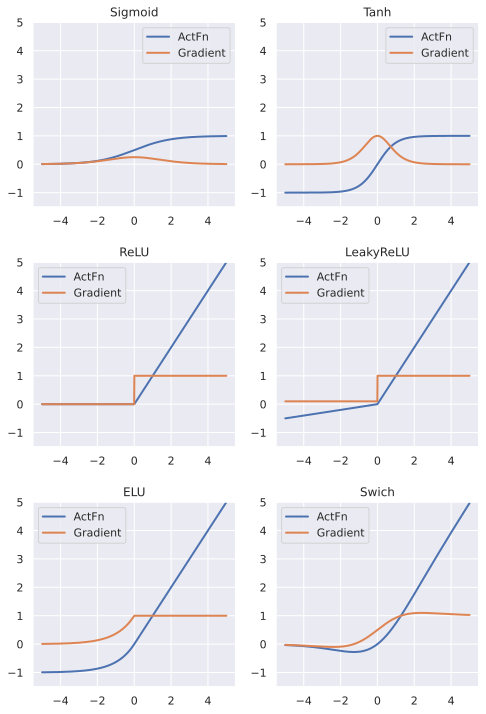

In [8]:
act_fns = [act_fn() for act_fn in act_fn_names.values()]
x = torch.linspace(-5, 5, 1000)

rows = math.ceil(len(act_fns)/2.0)
fig, ax = plt.subplots(rows, 2, figsize=(8, rows*4))
for i, act_fn in enumerate(act_fns):
    print(act_fn)
    vis_act_fn(act_fn, ax[divmod(i,2)], x)
fig.subplots_adjust(hspace=0.3)
plt.show()

In [9]:
print(type(act_fn_names))
print(act_fn_names.values())

<class 'dict'>
dict_values([<class '__main__.Sigmoid'>, <class '__main__.Tanh'>, <class '__main__.ReLU'>, <class '__main__.LeakyReLU'>, <class '__main__.ELU'>, <class '__main__.Swich'>])


## Analysing the effect of activation functions

After implementing and visualizing the activation functions, we are aiming to gain insights into their effect. 
We do this by using a simple neural network trained on [FashionMNIST](https://github.com/zalandoresearch/fashion-mnist) and examine various aspects of the model, including the performance and gradient flow.

### Setup

Firstly, let's set up a neural network. The chosen network views the images as 1D tensors and pushes them through a sequence of linear layers and a specified activation function. Feel free to experiment with other network architectures.

In [10]:
input_size=784
num_classes=10
hidden_sizes=[512, 256, 256, 128]
layers = []
layer_sizes = [input_size] + hidden_sizes
for layer_index in range(1, len(layer_sizes)):
    layers += [nn.Linear(layer_sizes[layer_index-1], layer_sizes[layer_index]),
               act_fn]
layers += [nn.Linear(layer_sizes[-1], num_classes)]
print(layers)
print(*layers)
#self.layers = nn.Sequential(*layers) # nn.Sequential summarizes a list of modules into a single module, applying them in sequence

[Linear(in_features=784, out_features=512, bias=True), Swich(), Linear(in_features=512, out_features=256, bias=True), Swich(), Linear(in_features=256, out_features=256, bias=True), Swich(), Linear(in_features=256, out_features=128, bias=True), Swich(), Linear(in_features=128, out_features=10, bias=True)]
Linear(in_features=784, out_features=512, bias=True) Swich() Linear(in_features=512, out_features=256, bias=True) Swich() Linear(in_features=256, out_features=256, bias=True) Swich() Linear(in_features=256, out_features=128, bias=True) Swich() Linear(in_features=128, out_features=10, bias=True)


In [11]:
layers = nn.Sequential(*layers)
layers

Sequential(
  (0): Linear(in_features=784, out_features=512, bias=True)
  (1): Swich()
  (2): Linear(in_features=512, out_features=256, bias=True)
  (3): Swich()
  (4): Linear(in_features=256, out_features=256, bias=True)
  (5): Swich()
  (6): Linear(in_features=256, out_features=128, bias=True)
  (7): Swich()
  (8): Linear(in_features=128, out_features=10, bias=True)
)

In [12]:
 '''
BaseNetwork is created in this Cell
some comments:

We can crerate the ANN by nn.Sequential(nn.Linear1(size1, size2),
                                        nn.ActivFunct,
                                        nn.Linear2(size2, size3),
                                        nn.ActivFunc,
                                        ===//===//===
                                        nn.Linera(sizeN, output))
This nn.Sequential is setted by list of layers and sctivation fucntion
We can transform list to Sequential. 
List of Layers and act.Func set be cycle FOR after super constructore

'''
class BaseNetwork(nn.Module):
    def __init__(self, act_fn, input_size=784, num_classes = 10, hidden_size = [512, 256, 256, 128]):
        super().__init__()

        # create the layers (tutorial version, my version is shown in next CELL)
        layers = []
        leyers_sizes = [input_size] + hidden_size
        
        for id_layer in range(1, len(leyers_sizes)):
            in_size = leyers_sizes[id_layer -1]
            out_size = leyers_sizes[id_layer ]
            layers += [ nn.Linear(in_size, out_size), act_fn ]
        layers += [nn.Linear(leyers_sizes[-1], num_classes)]
        self.layers = nn.Sequential(*layers)
        
        # We store all hyperparameterrs in a dictionary for saving and loading the model
        self.config = {"act_fn": act_fn.config, "input_size": input_size, "num_classes":num_classes, "hidden_size":hidden_size}
    def forward(self, x):
        #x = torch.flatten(x)
        #print(x.shape)
        #print(torch.flatten(x).shape)
        x = x.view(x.size(0), -1)
        #print(x.shape)
        out = self.layers(x)
        return out
            
        
        

In [13]:
class BaseNetworkMV(nn.Module):
    def __init__(self, act_fn, input_size=784, num_classes = 10, hidden_size = [512, 256, 256, 128]):
        super().__init__()
        self.lin1 = nn.Linear(input_size, 512)
        self.lin2 = nn.Linear(512, 256)
        self.lin3 = nn.Linear(256, 256)
        self.lin4 = nn.Linear(256, 128)
        self.lin5 = nn.Linear(128, num_classes)
        self.act_fn = act_fn
        self.config = {"act_fn": act_fn.config, "input_size": input_size, "num_classes":num_classes, "hidden_size":hidden_size}
        
    def forward(self, x):
        #print(x.shape)
        #print(torch.flatten(x).shape)
        x = x.view(x.size(0), -1)
        x = self.act_fn(self.lin1(x))
        x = self.act_fn(self.lin2(x))
        x = self.act_fn(self.lin3(x))
        x = self.act_fn(self.lin4(x))
        x = self.lin5(x)
        return x
    

In [14]:
def _get_config_file(model_path, model_name):
    # Name of the file for storing hyperparameter details
    return os.path.join(model_path, model_name + ".config")

def _get_model_file(model_path, model_name):
    # Name of the file for storing network parameters
    return os.path.join(model_path, model_name + ".tar")

def load_model(model_path, model_name, net = None):
    """
    Loads a saved model from disk.

    Inputs:
        model_path - Path of the checkpoint directory
        model_name - Name of the model (str)
        net - (Optional) If given, the state dict is loaded into this model. Otherwise, a new model is created.
    """
    config_file, model_file  = _get_config_file(model_path, model_name), _get_model_file(model_path, model_name)

    assert os.path.isfile(config_file), f"Could not find the config file \"{config_file}\""
    assert os.path.isfile(model_file),  f"Could not find the model file \"{model_file}\""

    with open(config_file, "r") as f:
        cofig_dict = json.load(f)
    if net is None:
        act_fn_name = config_dict["act_fn"].pop("name").lower()
        act_fn = act_fn_by_name[act_fn_name](**config_dict.pop("act_fn"))
        net = BaseNetwork(act_fn=act_fn, **config_dict)
    net.load_state_dict(torch.load(model_file, map_location=device))
    return net

def save_model(model, model_path, model_name):
    """
    Given a model, we save the state_dict and hyperparameters.

    Inputs:
        model - Network object to save parameters from
        model_path - Path of the checkpoint directory
        model_name - Name of the model (str)
    """
    config_dict = model.config
    os.makedirs(model_path, exist_ok=True)
    config_file, model_file = _get_config_file(model_path, model_name), _get_model_file(model_path, model_name)
    with open(config_file, "w") as f:
        json.dump(config_dict, f)
    torch.save(model.state_dict(), model_file)
        
    
    
    

We also set up the dataset we want to train it on, namely [FashionMNIST](https://github.com/zalandoresearch/fashion-mnist). FashionMNIST is a more complex version of MNIST and contains black-and-white images of clothes instead of digits. The 10 classes include trousers, coats, shoes, bags and more. To load this dataset, we will make use of yet another PyTorch package, namely `torchvision` ([documentation](https://pytorch.org/docs/stable/torchvision/index.html)). The `torchvision` package consists of popular datasets, model architectures, and common image transformations for computer vision. We will use the package for many of the notebooks in this course to simplify our dataset handling. 

Let's load the dataset below, and visualize a few images to get an impression of the data.

In [15]:
import torchvision
from torchvision.datasets import FashionMNIST
from torchvision import transforms

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,)) ])

# Load the training and test dataset
train_dataset = FashionMNIST(root = DATASET_PATH, train = True, transform = transform, download = True)

train_set, val_set = torch.utils.data.random_split(train_dataset,  [50000, 10000])

# load the test set
test_dataset = FashionMNIST(root = DATASET_PATH, train = False, transform = transform, download = True)

train_loader = data.DataLoader(train_set, batch_size = 1024, shuffle = True, drop_last = False)
val_loader = data.DataLoader(val_set, batch_size = 1024, shuffle = False, drop_last = False)
test_loader = data.DataLoader(test_dataset, batch_size = 1024, shuffle = False, drop_last = False)



In [16]:
print(type(train_set))
print(type(train_set[0]))

print(type(train_set[0][0]))
print(train_set[0][0].shape)

<class 'torch.utils.data.dataset.Subset'>
<class 'tuple'>
<class 'torch.Tensor'>
torch.Size([1, 28, 28])


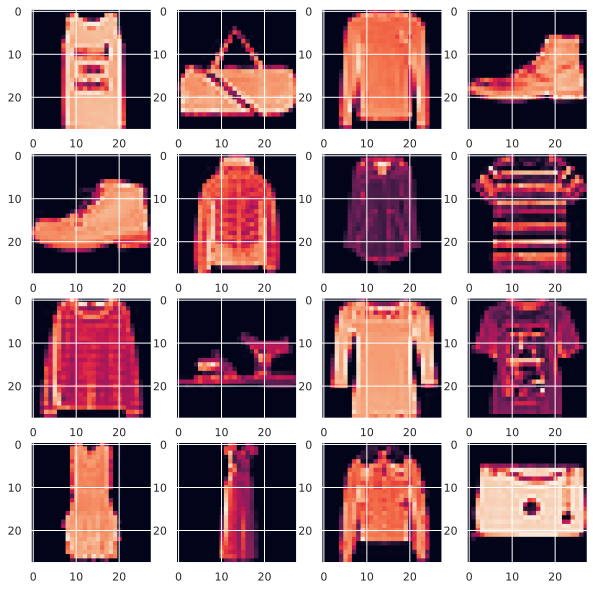

In [17]:
exmpl_imgs = [train_set[i][0] for i in range(16)]
fig, axs = plt.subplots(nrows=4, ncols=4, figsize = (10,10))
for i in range(4):
    for j in range(4):
        numpy_arr = exmpl_imgs[4*i + j].numpy()
        #print(numpy_arr.shape)
        #print(numpy_arr[0].shape)
        axs[i, j].imshow(numpy_arr[0])
        

Как упоминалось ранее, одним из важных аспектов функций активации является то, как они распространяют градиенты по сети. Представьте, что у нас есть очень глубокая нейронная сеть, состоящая более чем из 50 слоев. Градиенты входного слоя, то есть самого первого слоя, прошли более чем в 50 раз больше функции активации, но мы все равно хотим, чтобы они имели разумный размер. Если градиент через функцию активации (ожидается) значительно меньше 1, наши градиенты исчезнут, пока не достигнут входного слоя. Если градиент через функцию активации больше 1, градиенты экспоненциально увеличиваются и могут взорваться.

Чтобы понять, как каждая функция активации влияет на градиенты, мы можем взглянуть на только что инициализированную сеть и измерить градиенты для каждого параметра для пакета из 256 изображений:

In [18]:
# work with dataloader
example = next(iter(train_loader))
print(len(example))
print(example[0].shape)
print(example[1].shape)
print(example[1])
#print(example); # list of len 2. 


2
torch.Size([1024, 1, 28, 28])
torch.Size([1024])
tensor([8, 8, 6,  ..., 1, 6, 4])


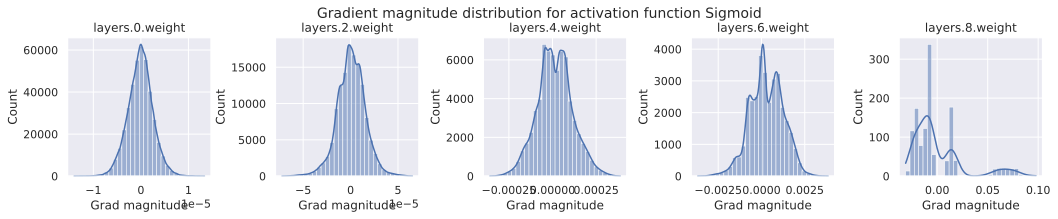

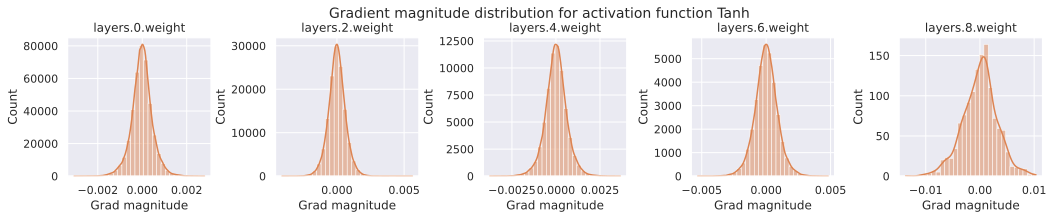

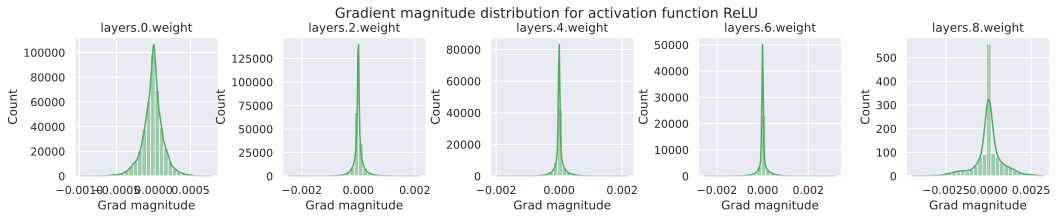

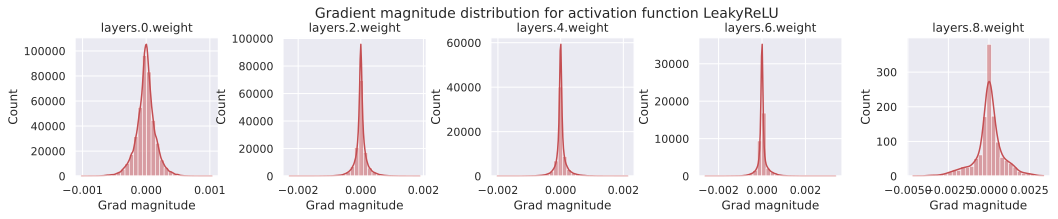

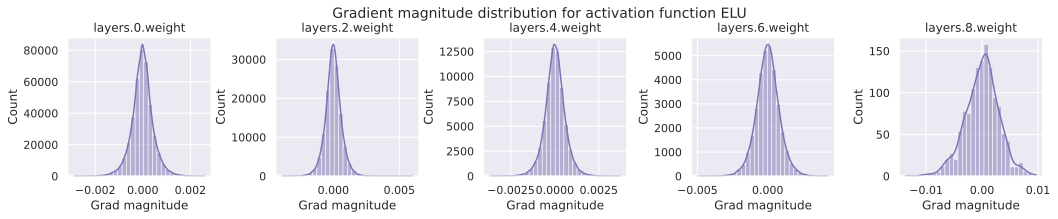

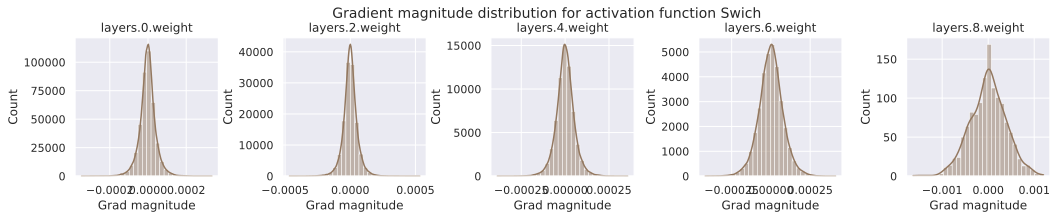

In [19]:
def visualize_gradients(net, color="C0"):
    """
    Input: net - object of class BaseNetwork
    """
    net.eval()
    small_loader = data.DataLoader(train_set, batch_size = 256, shuffle = True)
    imgs, labels = next(iter(small_loader))
    imgs, labels = imgs.to(device), labels.to(device)
    
    net.zero_grad()
    preds = net(imgs)
    loss  = F.cross_entropy(preds, labels)
    loss.backward()
    grads = {name: params.grad.data.view(-1).cpu().clone().numpy() for name, params in net.named_parameters() if "weight" in name}
    net.zero_grad()

    ## Plotting
    columns = len(grads)
    fig, ax = plt.subplots(1, columns, figsize=(columns*3.5, 2.5))
    fig_index = 0
    for key in grads:
        key_ax = ax[fig_index%columns]
        sns.histplot(data=grads[key], bins=30, ax=key_ax, color=color, kde=True)
        key_ax.set_title(str(key))
        key_ax.set_xlabel("Grad magnitude")
        fig_index += 1
    fig.suptitle(f"Gradient magnitude distribution for activation function {net.config['act_fn']['name']}", fontsize=14, y=1.05)
    fig.subplots_adjust(wspace=0.45)
    plt.show()
    plt.close()

# Seaborn prints warnings if histogram has small values. We can ignore them for now
import warnings
warnings.filterwarnings('ignore')
## Create a plot for every activation function
for i, act_fn_name in enumerate(act_fn_names):
    set_seed(42) # Setting the seed ensures that we have the same weight initialization for each activation function
    act_fn = act_fn_names[act_fn_name]()
    net_actfn = BaseNetwork(act_fn=act_fn).to(device)
    visualize_gradients(net_actfn, color=f"C{i}")    



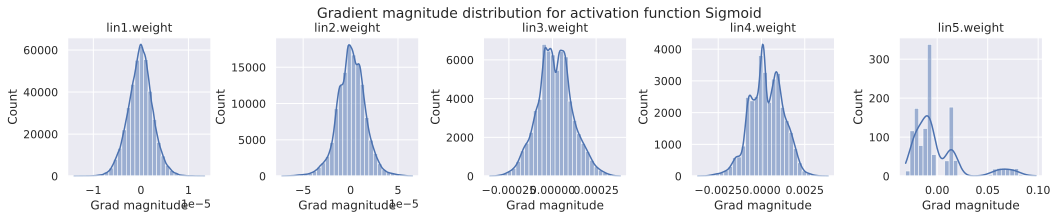

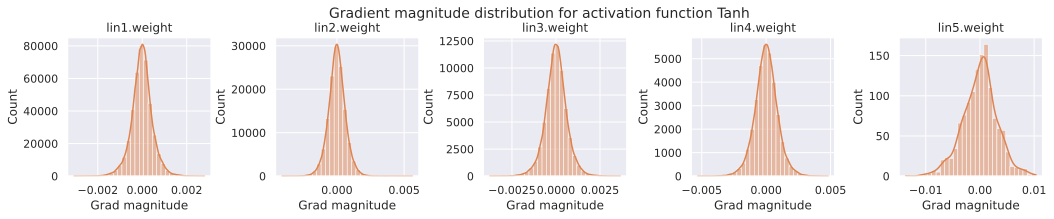

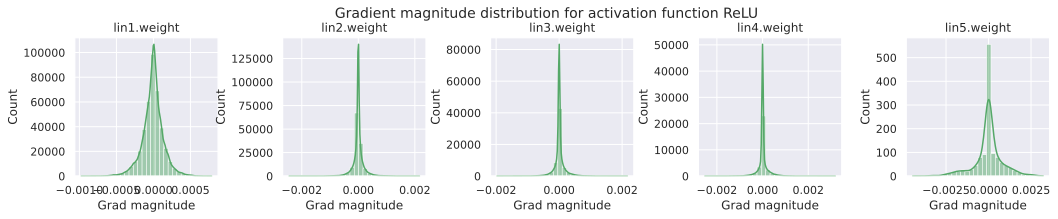

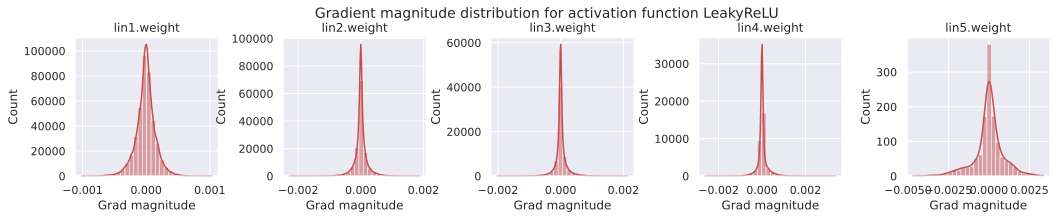

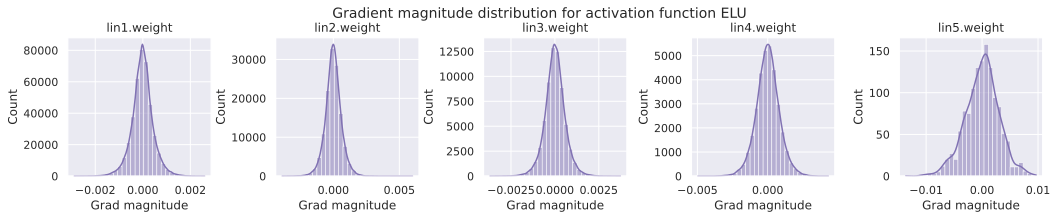

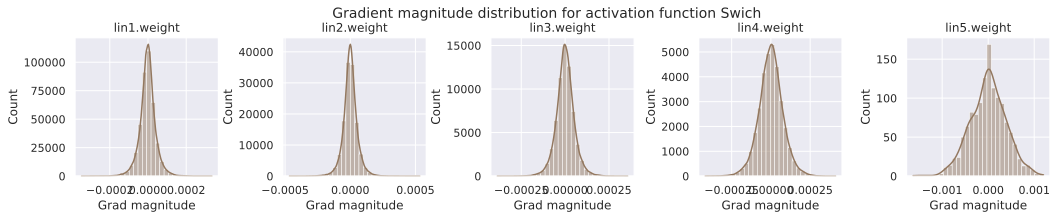

In [20]:
# Seaborn prints warnings if histogram has small values. We can ignore them for now
import warnings
warnings.filterwarnings('ignore')
## Create a plot for every activation function
for i, act_fn_name in enumerate(act_fn_names):
    set_seed(42) # Setting the seed ensures that we have the same weight initialization for each activation function
    act_fn = act_fn_names[act_fn_name]()
    net_actfn = BaseNetworkMV(act_fn=act_fn).to(device)
    visualize_gradients(net_actfn, color=f"C{i}")    


Функция активации сигмоиды демонстрирует явно нежелательное поведение. Хотя градиенты выходного слоя очень велики — до 0,1, входной слой имеет самую низкую норму градиента среди всех функций активации — всего 1e-5. Это связано с небольшим максимальным градиентом 1/4, и в этой настройке невозможно найти подходящую скорость обучения для всех слоев. Все остальные функции активации имеют одинаковые нормы градиента на всех слоях. Интересно, что активация ReLU имеет всплеск около 0, что вызвано его нулевой частью слева и мертвыми нейронами (мы рассмотрим это подробнее позже).

Обратите внимание, что помимо активации решающее значение может иметь инициализация весовых параметров. По умолчанию PyTorch использует инициализацию Kaiming для линейных слоев, оптимизированных для активации ReLU. В уроке 4 мы более подробно рассмотрим инициализацию, но предположим, что инициализация Кайминга достаточно хорошо работает для всех функций активации.

### Training a model

Next, we want to train our model with different activation functions on FashionMNIST and compare the gained performance. All in all, our final goal is to achieve the best possible performance on a dataset of our choice. 
Therefore, we write a training loop in the next cell including a validation after every epoch and a final test on the best model:

In [33]:
def train_model(net, model_name, max_epochs=50, patience=7, batch_size=256, overwrite=False):
    """
    Train a model on the training set of FashionMNIST
    
    Inputs:
        net - Object of BaseNetwork
        model_name - (str) Name of the model, used for creating the checkpoint names
        max_epochs - Number of epochs we want to (maximally) train for
        patience - If the performance on the validation set has not improved for #patience epochs, we stop training early
        batch_size - Size of batches used in training
        overwrite - Determines how to handle the case when there already exists a checkpoint. If True, it will be overwritten. Otherwise, we skip training.
    """
    file_exists = os.path.isfile(_get_model_file(CHECKPOINT_PATH, model_name))
    if file_exists and not overwrite:
        print("Model file already exists. Skipping training...")
    else:
        if file_exists:
            print("Model file exists, but will be overwritten...")
        # define optimizer, loss, and DataLoader
        optimizer = torch.optim.SGD(net.parameters(), lr=0.01, momentum=0.9)
        loss_model = nn.CrossEntropyLoss()
        train_loader_local = data.DataLoader(train_set, batch_size=batch_size, shuffle=True, drop_last=True, pin_memory=True)
        
        val_score = []
        best_val_epoch = []
        counter = 0
        for epoch in range(1):#max_epochs):
            # trainig part
            net.train()
            true_preds, count = 0, 0
            for x_batch, labels in train_loader_local:
                if counter == 1:
                    break
                x_batch, labels = x_batch.to(device), labels.to(device)
               
                
                # zeros grad
                optimizer.zero_grad()                
                
                # froward pass
                preds = net(x_batch)
                loss = loss_model(preds, labels)
                
                #print(x_batch.shape)
                #print(preds.shape)
                #print("preds[0]: ", preds[0])
                #print("labels", labels)
                #print("preds.argmax(dim=-1):", preds.argmax(dim=-1))
                true_preds += (preds.argmax(dim=-1) == labels).sum()
                
                #backeard pass
                loss.backward()
                optimizer.step()
                                
                counter += labels.shape[0]
            train_acc = true_preds / counter

            # validation
            val_acc = test_model(net, val_loader)
            val_scores.append(val_acc)
            print(f"[Epoch {epoch+1:2d}] Training accuracy: {train_acc*100.0:05.2f}%, Validation accuracy: {val_acc*100.0:05.2f}%")

            if len(val_scores) == 1 or val_acc > val_scores[best_val_epoch]:
                print("\t   (New best performance, saving model...)")
                save_model(net, CHECKPOINT_PATH, model_name)
                best_val_epoch = epoch
            elif best_val_epoch <= epoch - patience:
                print(f"Early stopping due to no improvement over the last {patience} epochs")
                break
                
        # Plot a curve of the validation accuracy
        plt.plot([i for i in range(1,len(val_scores)+1)], val_scores)
        plt.xlabel("Epochs")
        plt.ylabel("Validation accuracy")
        plt.title(f"Validation performance of {model_name}")
        plt.show()
        plt.close()

                
                
        

In [35]:
for act_fn_name in act_fn_names:
    print(f"Training BaseNetwork with {act_fn_name} activation...")
    set_seed(42)
    act_fn = act_fn_names[act_fn_name]()
    net_actfn = BaseNetwork(act_fn=act_fn).to(device)
    train_model(net_actfn, f"FashionMNIST_{act_fn_name}", overwrite=True)

Training BaseNetwork with sigmoid activation...
Model file exists, but will be overwritten...


NameError: name 'test_model' is not defined